# Import library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# VGGNet

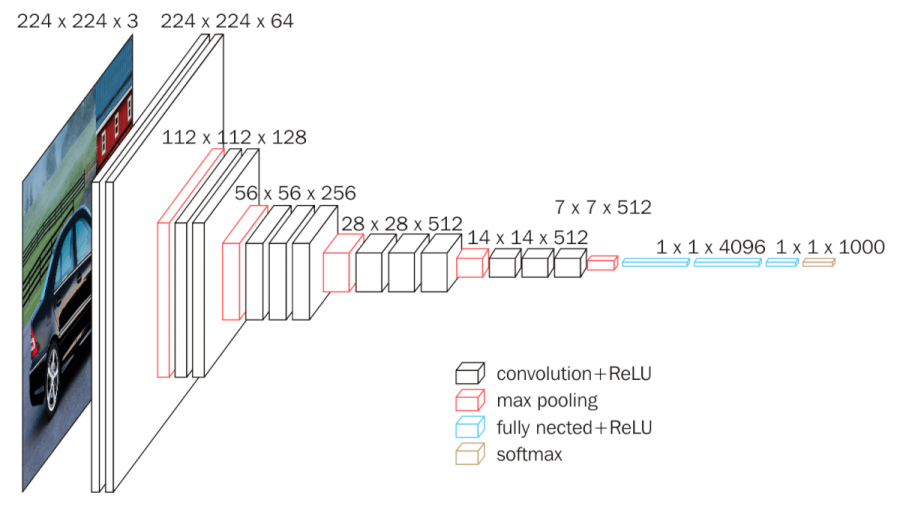

In [3]:
class VGGNet(nn.Module):
    def __init__(self, num_classes=10):
        super(VGGNet, self).__init__()
        
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2,2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=(8*64*1*1), out_features=4096), # CIFAR10 (32 x 32)
            # nn.Linear(in_features=(8*64*7*7), out_features=4096), # IMAGENET (224 x 224)
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=4096, out_features=1000),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=1000, out_features=num_classes)
        )
        
    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Data

In [9]:
batch_size = 512
lr = 0.0001

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = datasets.CIFAR10(root='./CIFAR10', train=True, download=False, transform=transform)
test_set = datasets.CIFAR10(root='./CIFAR10', train=False, download=False, transform=transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [5]:
model = VGGNet().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=lr)

for i in model.named_children():
    print(i)

('feature', Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU()
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU()
  (19): Conv2d(

# Train

In [6]:
num_epochs = 50
loss_arr = []
for i in range(num_epochs):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()

    if i % 10 ==0:
        print(loss)
        loss_arr.append(loss.cpu().detach().numpy())

tensor(2.3033, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8559, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6578, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2957, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1009, device='cuda:0', grad_fn=<NllLossBackward0>)


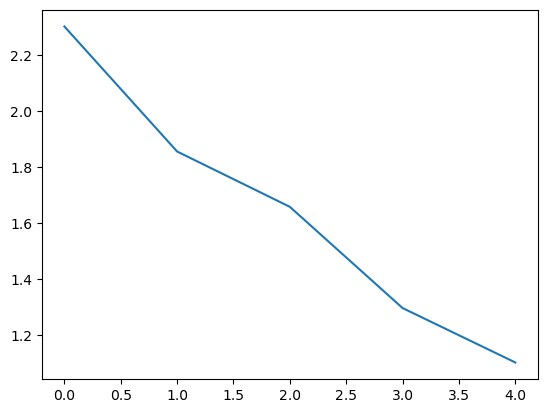

In [7]:
import matplotlib.pyplot as plt

plt.plot(loss_arr)
plt.show()

In [10]:
correct = 0 # 맞은 개수
total = 0   # 전체 개수

model.eval()
with torch.no_grad():
    for image,label in test_loader:
        
        x = image.to(device)
        y = label.to(device)

        output = model.forward(x)
        # torch.max를 이용해 최대 값 및 최대값 인덱스를 뽑아냄 (인덱스만 사용)
        _,output_index = torch.max(output,1)
        
        # 전체 개수는 라벨의 개수로 더해줌 (batch_size, drop_last의 영향으로 데이터가 잘릴 수도 있기 때문에)
        total += label.size(0)
        
        # 모델의 결과의 최대값 인덱스와 라벨이 일치하는 개수를 더해줌
        correct += (output_index == y).sum().float()
    
    print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 71.98999786376953%
